# Agent Based Models

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [42]:
%matplotlib inline

import math
import time
from dataclasses import dataclass

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Helpers
We're starting to collect some useful re-usable bits of code - we should consider putting these in an importable module...

In [43]:
# Define a colour map for black, red, blue.
cmap = [(0, 0, 0), (1, 0, 0), (0, 0, 1)]
shellings_colour_map = matplotlib.colors.ListedColormap(cmap)
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = shellings_colour_map,
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [52]:
def legend(axes=None, **options):
    """Draws a legend only if there is at least one labeled data series.

    :param axes: the axes to add the legend to, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.legend()`
           see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html
    """
    options = { **dict(loc="best", frameon=False), **options}

    ax = axes or plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, **options)

In [ ]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step*self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## Schelling's model

`locs_where` is a wrapper on `np.nonzero` that returns results as a list of tuples.

In [45]:
def locs_where(condition):
    """Find cells where a logical array is True.
    
    condition: logical array
    
    returns: list of location tuples
    """
    return list(zip(*np.nonzero(condition)))

Here's my implementation of Schelling's model:

In [46]:

class Schelling:
    """Represents a grid of Schelling agents."""
    
    EMPTY = 0
    RED = 1
    BLUE = 2

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    def __init__(self, n, p):
        """Initializes the attributes.

        n: number of rows
        p: threshold for happy/unhappy with the fraction of similar neighbors
        """
        self.p = p
        
        probs = [0.1, 0.45, 0.45]
        self.array = np.random.choice([self.EMPTY, self.RED, self.BLUE], (n, n), p=probs)

    def count_neighbors(self):
        """Surveys neighboring cells.
        
        returns: tuple of
            empty: True where cells are empty
            frac_red: fraction of red neighbors around each cell
            frac_blue: fraction of blue neighbors around each cell
            frac_same: fraction of neighbors with the same color
        """
        a = self.array
        
        empty = a==self.EMPTY
        red = a==self.RED
        blue = a==self.BLUE

        # count red neighbors, blue neighbors, and total
        num_red = correlate2d(red, self.kernel, mode='same', boundary='wrap')
        num_blue = correlate2d(blue, self.kernel, mode='same', boundary='wrap')
        num_neighbors = num_red + num_blue

        # compute fraction of similar neighbors
        frac_red = num_red / num_neighbors
        frac_blue = num_blue / num_neighbors
        
        # no neighbors is considered the same as no similar neighbors 
        # (this is an arbitrary choice for a rare event)
        frac_red[num_neighbors == 0] = 0
        frac_blue[num_neighbors == 0] = 0
        
        # for each cell, compute the fraction of neighbors with the same color
        frac_same = np.where(red, frac_red, frac_blue)

        # for empty cells, frac_same is NaN
        frac_same[empty] = np.nan
        
        return empty, frac_red, frac_blue, frac_same

    def segregation(self):
        """Computes the average fraction of similar neighbors.
        
        returns: fraction of similar neighbors, averaged over cells
        """
        _, _, _, frac_same = self.count_neighbors()
        return np.nanmean(frac_same)
    
    def step(self):
        """Executes one time step.
                
        returns: fraction of similar neighbors, averaged over cells
        """
        a = self.array
        empty, _, _, frac_same = self.count_neighbors()
        
        # find the unhappy cells (ignore NaN in frac_same)
        with np.errstate(invalid='ignore'):
            unhappy = frac_same < self.p
        unhappy_locs = locs_where(unhappy)
        
        # find the empty cells
        empty_locs = locs_where(empty)

        # shuffle the unhappy cells
        if len(unhappy_locs):
            np.random.shuffle(unhappy_locs)
            
        # for each unhappy cell, choose a random destination
        num_empty = np.sum(empty)
        for source in unhappy_locs:
            i = np.random.randint(num_empty)
            dest = empty_locs[i]
            
            # move
            a[dest] = a[source]
            a[source] = 0
            empty_locs[i] = source
        
        # check that the number of empty cells is unchanged
        num_empty2 = np.sum(a==0)
        assert num_empty == num_empty2
        
        # return the average fraction of similar neighbors
        return np.nanmean(frac_same)
        
    def draw(self, axes=None, step=''):
        """Draws the cells on given axes."""
        axes = axes or plt.gca()  # use current axes if none are provided.
        plot_2D_array(self.array, axes,  title=f'Shelling @ step {step}')

Here's a small example.

0.5237462006079027

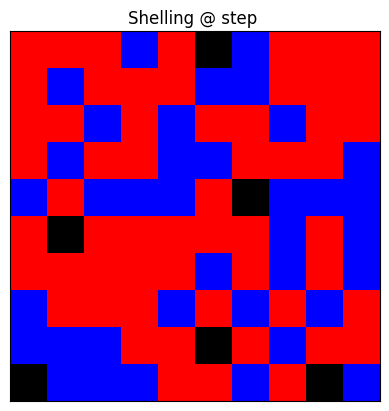

In [47]:
grid = Schelling(n=10, p=0.3)
grid.draw()
grid.segregation()

And here's an animation for a bigger example.
The degree of segregation increases quickly.

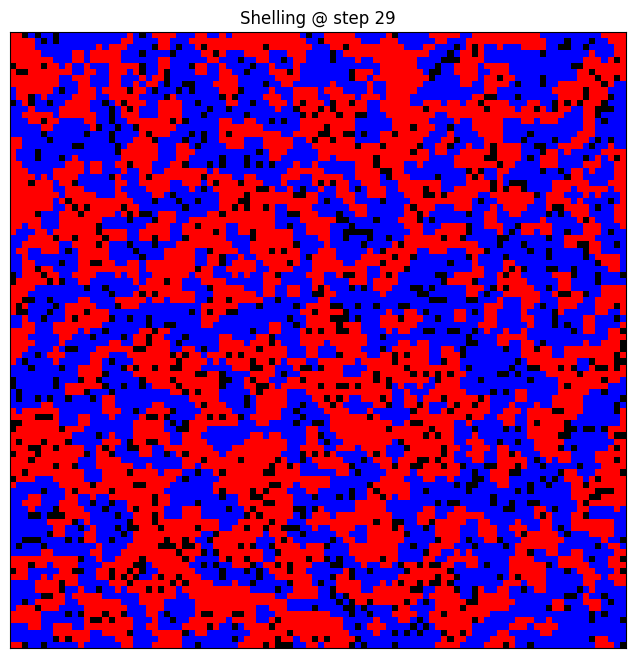

In [48]:
model = Schelling(n=100, p=0.3)
anim = Animation2D(model, frames=30)
anim.animate()

The following figure shows the process after a few steps.

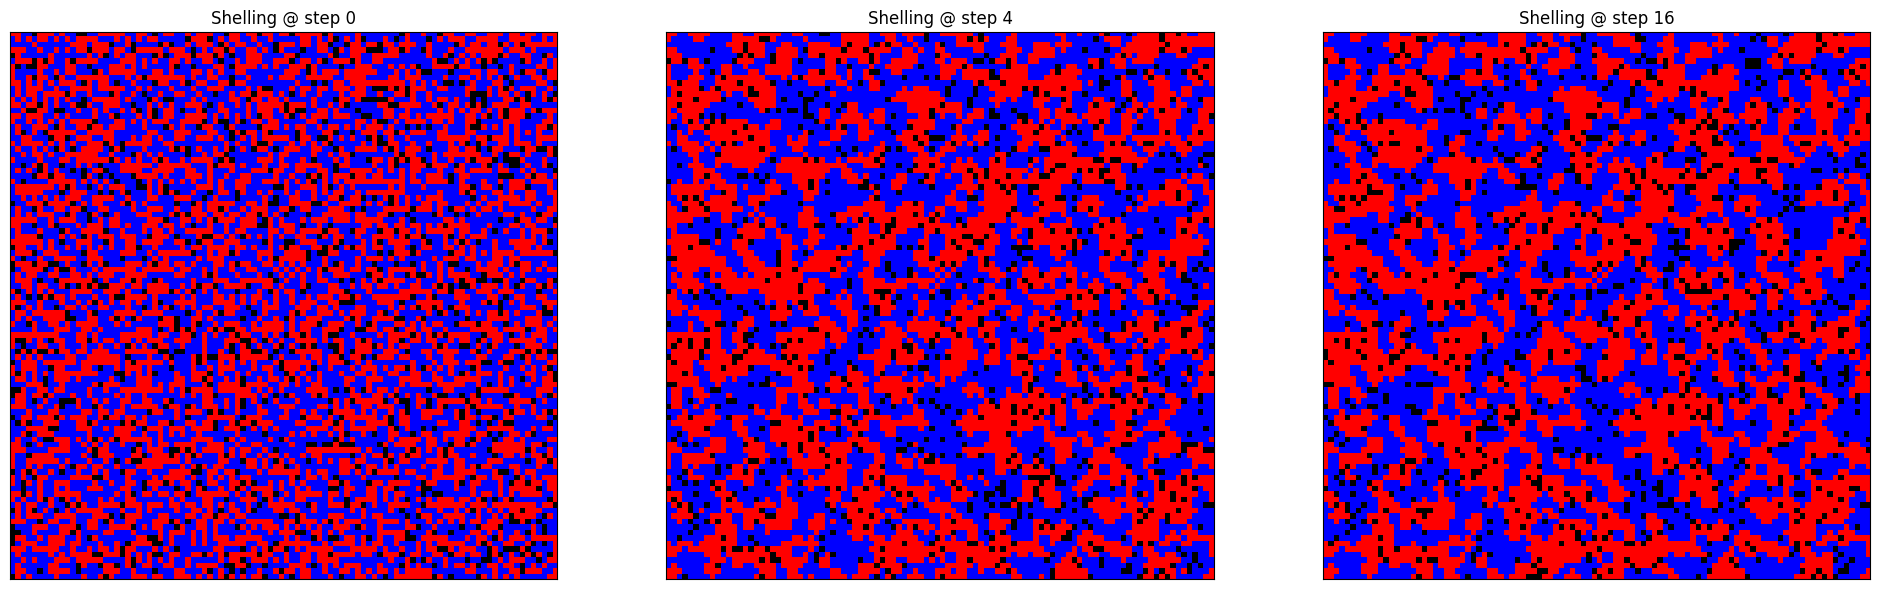

In [49]:
model = Schelling(n=100, p=0.3)

_, ax = plt.subplots(1, 3, figsize=(24, 8))
model.draw(ax[0], step=0) 

draw_at = (0, 4, 16)

for step in range(1, draw_at[-1]+1):
    model.step()
    if step in draw_at:
        model.draw(ax[draw_at.index(step)], step=step) 

And here's how segregation in steady state relates to `p`, the threshold on the fraction of similar neighbors.

0.5 0.8707797990077598 0.3707797990077598
0.4 0.8181252110773387 0.4181252110773387
0.3 0.7538847395404771 0.4538847395404771
0.2 0.5729593164353953 0.3729593164353953


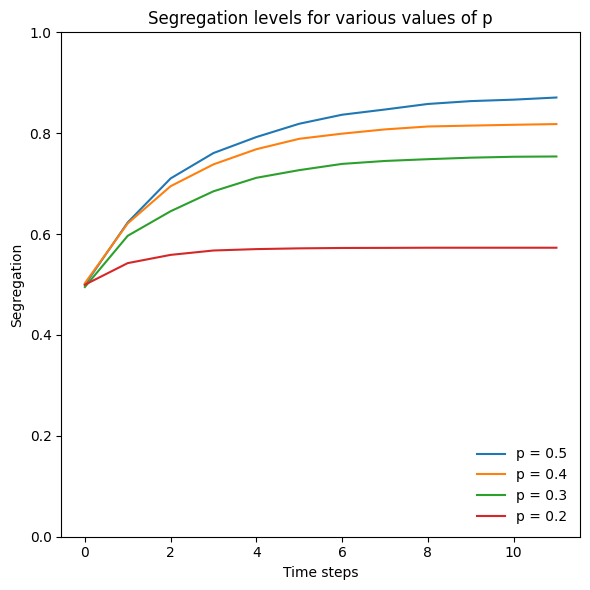

In [61]:
_, ax = plt.subplots(figsize=(6, 6), layout='tight') 
ax.set(
    title=f'Segregation levels for various values of p',
    xlabel='Time steps', 
    ylabel='Segregation',
    ylim=[0, 1]
)

np.random.seed(17)
for p in [0.5, 0.4, 0.3, 0.2]:
    model = Schelling(n=100, p=p)
    segs = [model.step() for i in range(12)]
    ax.plot(segs, label='p = %.1f' % p)
    print(p, segs[-1], segs[-1] - p)


legend(axes=ax, loc='lower right')
plt.show()

At `p=0.3`, there is a striking difference between the level that would make people happy, at only 30%, and the level they actually get, around 75%.

**Exercise:** Experiment with different starting conditions: for example, more or fewer empty cells, or unequal numbers of red and blue agents.